# Cyber Data Analysis Assignment 2
## SWaT Anomony Detection

## group number: 29


### Task 1: familiarization
In this assignment, we used Python as our analysis platform. If you want to run this Notebook, you need to install a library: statsmodels.

For familiarization task, first we loaded the sensor data, then we did some visualization tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [3]:
normal_df = pd.read_excel('Physical/SWaT_Dataset_Normal_v0.xlsx', header=1, index_col=' Timestamp')

In [4]:
X_train = normal_df.drop('Normal/Attack',axis=1,inplace=False)
X_train.index = pd.to_datetime(X_train.index, dayfirst = True, errors='ignore')

#### Question 1: How many different types of signals are there? What types of signals are these?
There are two types of signals: sensor signal and actuator signal. These signals were collected from six-stage filtration process.

In [5]:
X_train.columns

Index([u'FIT101', u'LIT101', u'MV101', u'P101', u'P102', u'AIT201', u'AIT202',
       u'AIT203', u'FIT201', u'MV201', u'P201', u'P202', u'P203', u'P204',
       u'P205', u'P206', u'DPIT301', u'FIT301', u'LIT301', u'MV301', u'MV302',
       u'MV303', u'MV304', u'P301', u'P302', u'AIT401', u'AIT402', u'FIT401',
       u'LIT401', u'P401', u'P402', u'P403', u'P404', u'UV401', u'AIT501',
       u'AIT502', u'AIT503', u'AIT504', u'FIT501', u'FIT502', u'FIT503',
       u'FIT504', u'P501', u'P502', u'PIT501', u'PIT502', u'PIT503', u'FIT601',
       u'P601', u'P602', u'P603'],
      dtype='object')

#### Question 2: Are the signals correlated?
As shown in the next cell, some of the signals are strongly correlated, such as FIT-101 and MV-101. The redness indicates the strength of positive correlation, and the greeness indicates the strength of negative correlation.

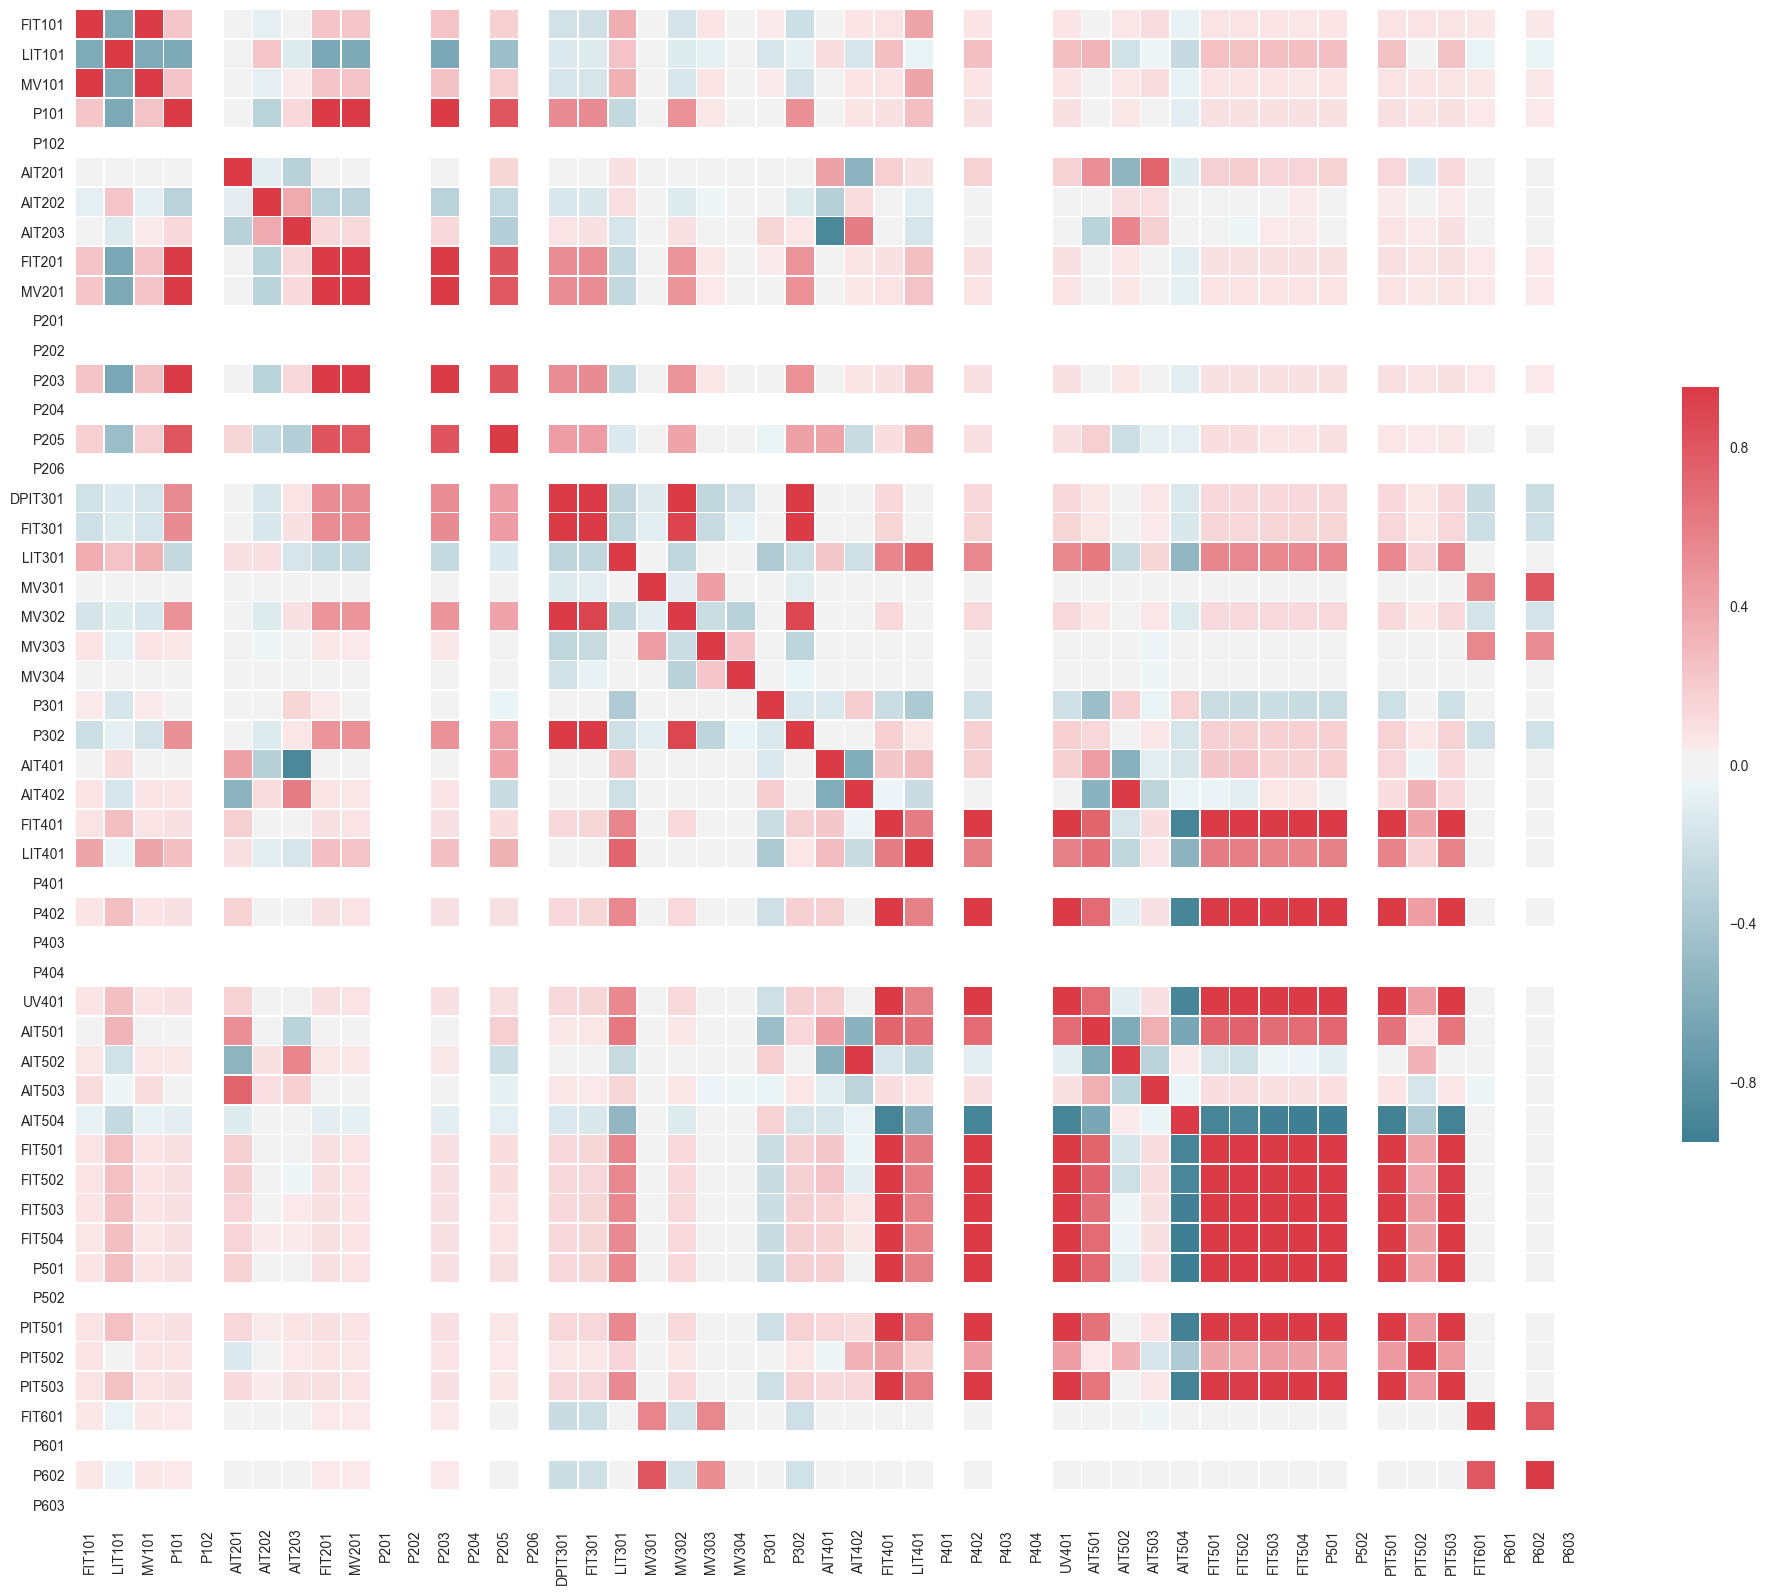

In [6]:
sns.set(style="white")
# Compute the correlation matrix
corr = X_train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3,
            square=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values,
            linewidths=0.5, cbar_kws={"shrink": .5}, ax=ax)

#### Visualization of FIT101 and LIT101
We noticed that at the begining, both signals behaved a little bit strange. This was due to the initialization and stablization. It took about 5~6 hours for SWaT to stablise. Hence, in the coming tasks, we removed those singals in the start.

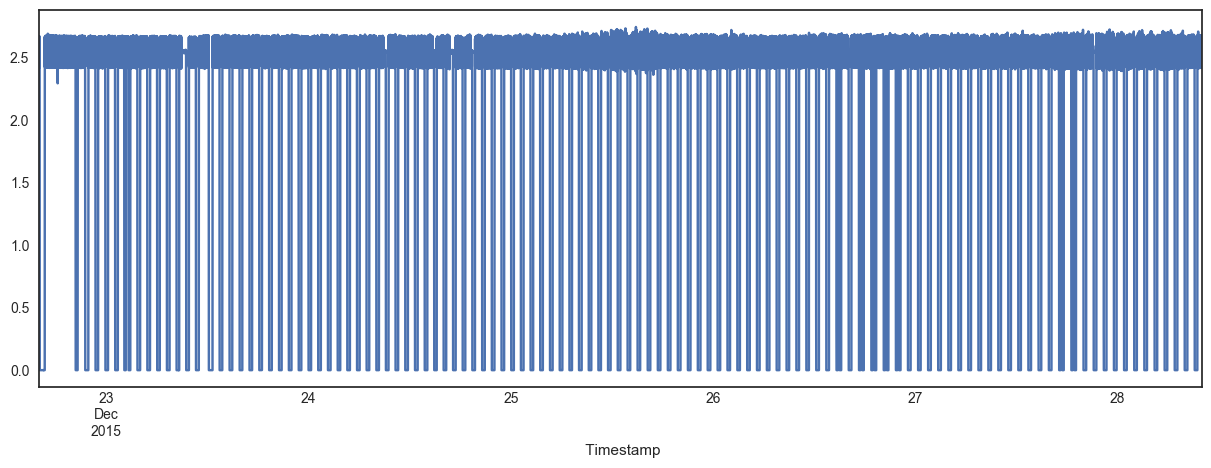

In [7]:
X_train.FIT101.plot(figsize=(15,5))

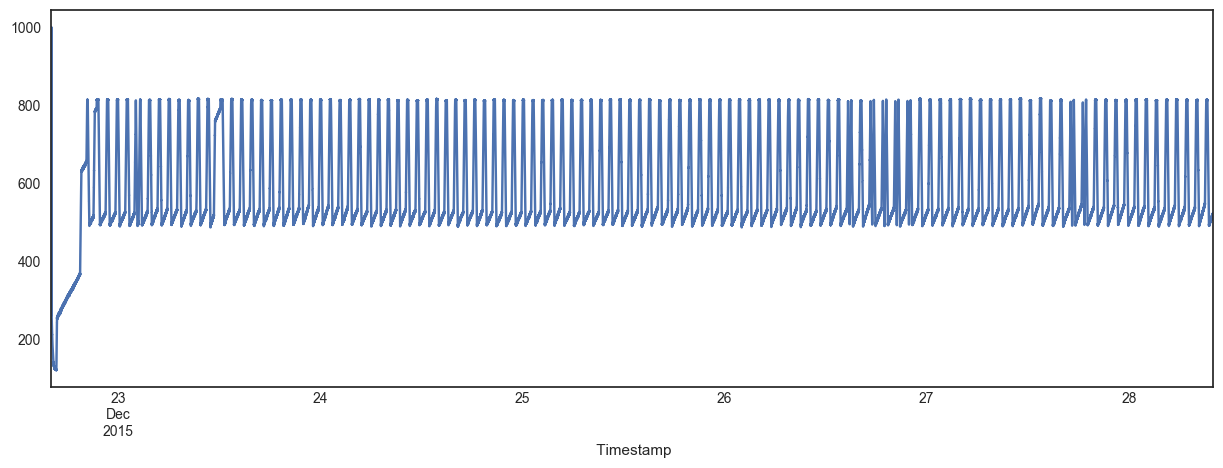

In [8]:
X_train.LIT101.plot(figsize=(15,5))

#### Training and testing splitting
Here we simply used sigals in the first table to be training data, and sigals in the second table to be testing data. Some cleaning was done here.

In [11]:
attack_df = pd.read_excel('Physical/SWaT_Dataset_Attack_v0.xlsx', header=1, index_col=' Timestamp')

In [12]:
X_test = attack_df.drop('Normal/Attack',axis=1,inplace=False)
X_test.index = pd.to_datetime(X_test.index, dayfirst = True, errors='ignore')
X_test = X_test.rename(columns={c:c.strip() for c in X_test.columns})

In [13]:
y = attack_df['Normal/Attack']
y.index = X_test.index

In [14]:
y_test = y.map({'Normal':0,'Attack':1}) # map the label to the number

In [15]:
y_test.index = pd.to_datetime(X_test.index, dayfirst = True, errors='ignore')

In [16]:
y_test = y_test.fillna(1) # deal with mistake in the SWaT_Dataset_Attack_v0.xlsx (‘ A ttack’). 
y_test[y_test.isnull()]

Series([], Name: Normal/Attack, dtype: float64)

### PCA Task
For ARMA task, we did it in several steps:  
1. Normalization  
2. PCA analysis on training data
3. Tune the threshold  
4. apply the same normalization and PCA transform on the test data

#### Step 1   apply pca on the original training data ’X_train‘.


* First, we need to normalize the input matrix (zero mean and unit variance)

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_nom = scaler.transform(X_train)
#print 'mean:',X_train_nom.mean(axis=0) #inspect the mean and the variance
#print 'variance:', X_train_nom.std(axis=0)

* Then, we need to apply pca on the data

In [18]:
 # function of deciding the number of eigenvalue to use for PCA
def percentage2n(eigVals,percentage):  
    sortArray=np.sort(eigVals)   
    sortArray=sortArray[-1::-1]   
    arraySum=sum(sortArray)  
    tmpSum=0  
    num=0  
    for i in sortArray:  
        tmpSum+=i  
        num+=1  
        if tmpSum>=arraySum*percentage:  
            return num,sortArray

In [19]:
# find the number of eigenvalue
covMat=np.cov(X_train_nom,rowvar=0)
eigVals,eigVects=np.linalg.eig(np.mat(covMat)) 
num,sortArray = percentage2n(eigVals,0.99)
print 'Number of principle component:',num    # 6 principle component
#print 'array of eigenvalue:',sortArray        # variance

Number of principle component: 21


In [20]:
# define the function of PCA. return the reconstructed data and principle eigenvectors.
def pca(newData,n):   
    covMat=np.cov(newData,rowvar=0)    #calculate covariance matrix  
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))  
    eigValIndice=np.argsort(eigVals)             
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]    
    n_eigVect=eigVects[:,n_eigValIndice]         
    lowDDataMat=newData*n_eigVect                
    reconMat=(lowDDataMat*n_eigVect.T)  #reconstructed data 
    return n_eigVect,reconMat  

In [21]:
P,X_train_rec = pca(X_train_nom,num)

* Compute and plot the residual

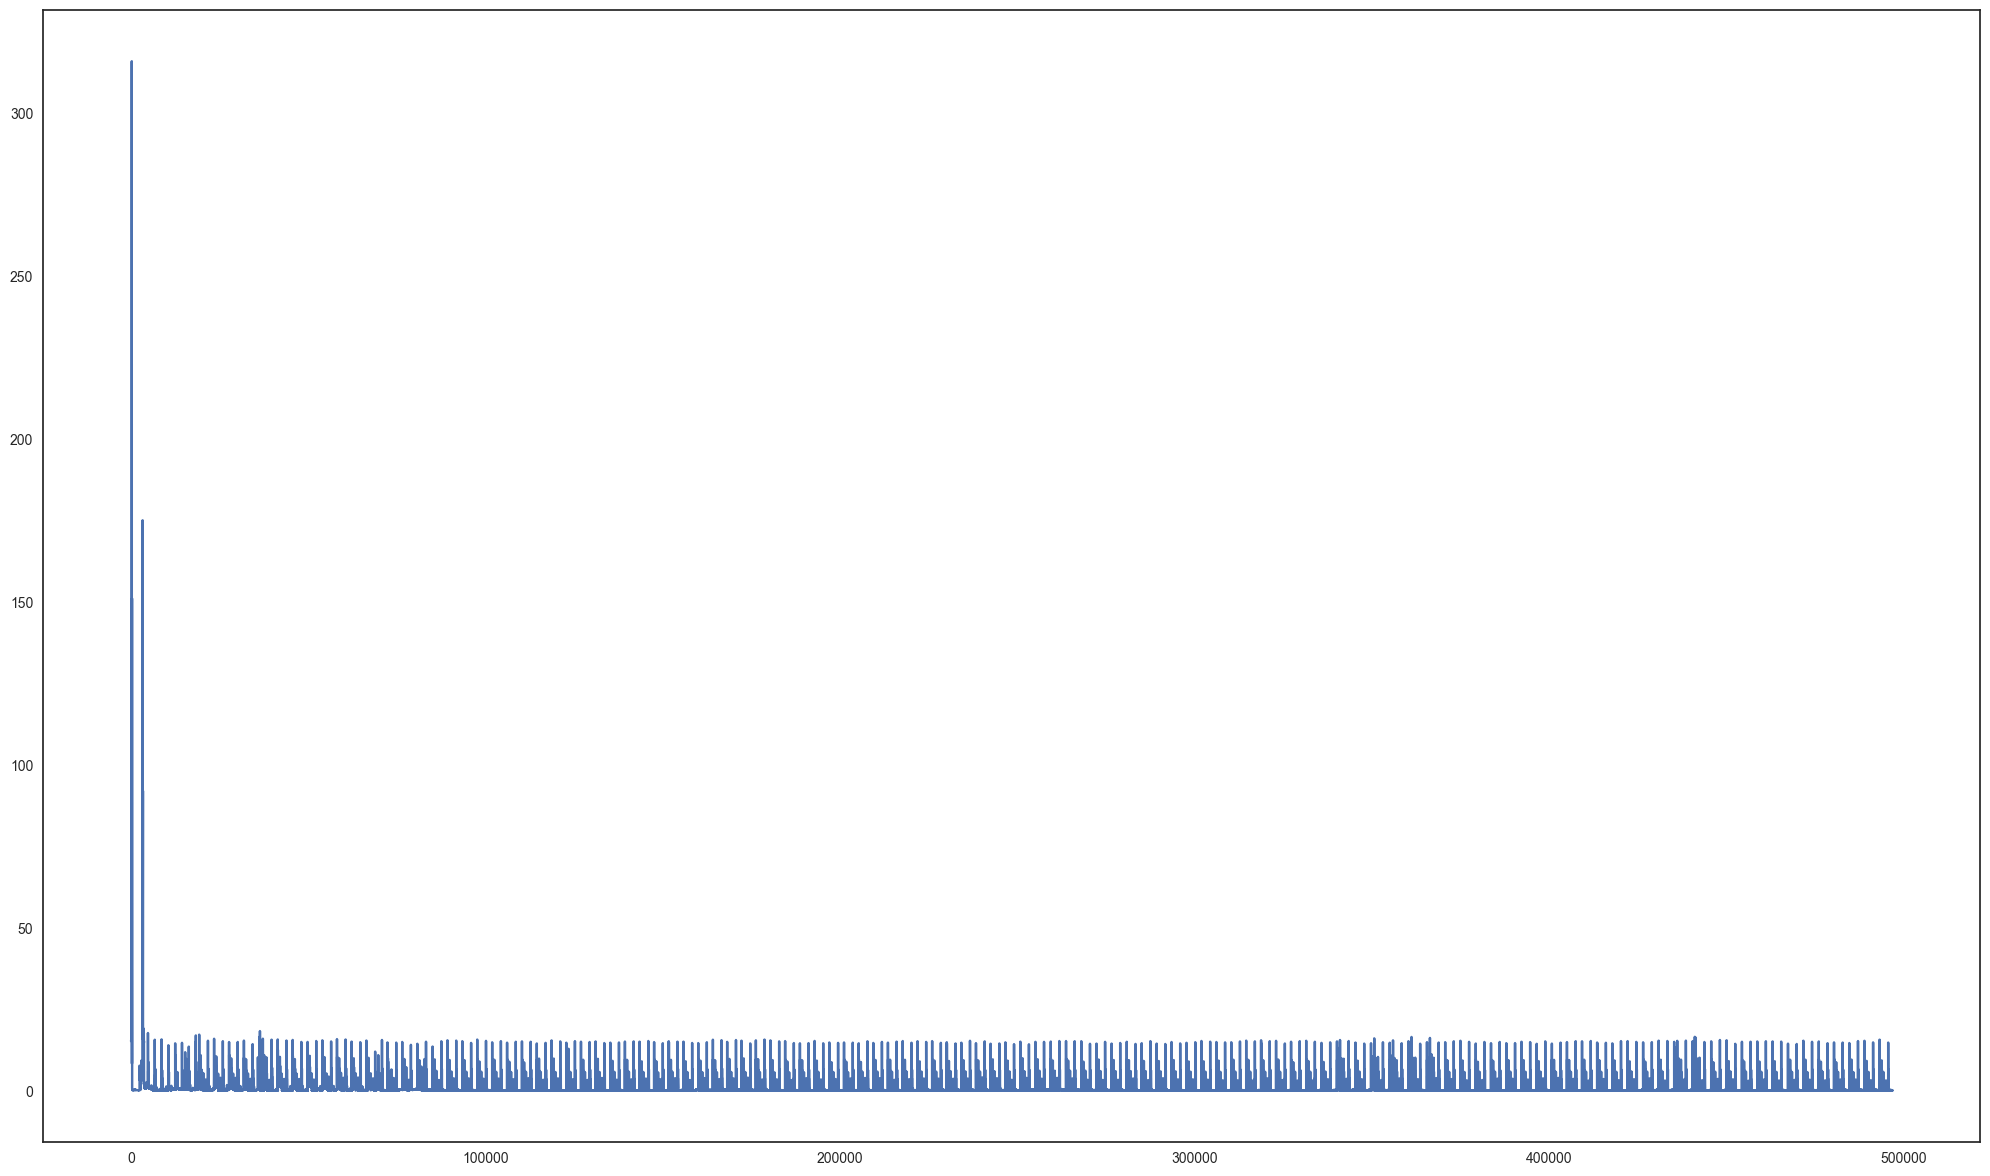

In [22]:
residual_pca1 = X_train_nom - X_train_rec
residual_pca2 = np.square(residual_pca1)
residual_pca = residual_pca2.sum(axis=1) 

figure, ax = plt.subplots(figsize=[25,15])
plt.figure(figsize=[25,10])
ax.plot(residual_pca)

In the figure above, there are large abnormalities at the beginning of training data. It is because of the unstability of the machine when starts, which is consistent with the last two figure in the Familiarization task. So in the next steps, the data of the first day was removed.

#### Step 2   Apply the pca on the data after removing and tune the threshold.

In [23]:
# we removed the data of 2015-12-22 due to its unstability.
X_train_1 = X_train['2015-12-23':]

In [24]:
#first, we need to normalize the input matrix (zero mean and unit variance)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_1)
X_train_nom = scaler.transform(X_train_1)
#print 'mean:',X_train_nom.mean(axis=0)
#print 'variance:',X_train_nom.std(axis=0)

* Find the number of eigenvalue

In [25]:
# find the number of eigenvalue
covMat=np.cov(X_train_nom,rowvar=0)
eigVals,eigVects=np.linalg.eig(np.mat(covMat)) 
num,sortArray = percentage2n(eigVals,0.99)
print 'number of principle component:',num     # 6 principle component
print 'array of eigenvector:',sortArray # variance

number of principle component: 23
array of eigenvector: [  9.49166027e+00   7.44438000e+00   4.40343399e+00   2.84987280e+00
   2.54677990e+00   1.99501310e+00   1.33157200e+00   1.00027802e+00
   9.41453648e-01   8.31209883e-01   7.00159780e-01   5.56289183e-01
   4.56003155e-01   3.80328539e-01   3.75811108e-01   2.88442751e-01
   2.77810730e-01   1.99256096e-01   1.75551842e-01   1.50429280e-01
   1.13411823e-01   1.01105001e-01   7.67021848e-02   5.87768630e-02
   4.94841207e-02   4.42483546e-02   3.47968265e-02   2.82205349e-02
   2.22082182e-02   2.18363949e-02   1.46928766e-02   1.23791499e-02
   1.15708489e-02   6.32401457e-03   5.91830709e-03   2.25607278e-03
   4.11403145e-04   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


* In practice, we decided to only use the smallest non-zero eigenvalue as the residual part.

In [26]:
num=36 ## only use the smallest non-zero eigenvalue.
P,X_train_rec = pca(X_train_nom,num)

* We tried several number of principle component and $C_\alpha$. Finally, 36 and 2.99  was chosen.

In [27]:
#calculate the threshold, according to the paper "Diagnosing Network-Wide Traffic Anomalies"
lambda1 = sortArray
lambda2 = np.power(sortArray,2)
lambda3 = np.power(sortArray, 3)

fi1 = sum(lambda1[num:])
fi2 = sum(lambda2[num:])
fi3 = sum(lambda3[num:])
h0 = 1-2.0*fi1*fi3 /(3*(fi2**2))
Ca=2.99
threshold = fi1 * np.power(1.0 * Ca * np.sqrt(2* fi2 * (h0 ** 2)) / fi1
                           + 1 + 1.0 * fi2 * h0 * (h0-1) / (fi1 ** 2) , 1.0 / h0)
print fi1,fi2,fi3,h0,threshold

0.000411403145088 1.69252547788e-07 6.96310304744e-11 0.333333333333 0.00430505933748


percentage of Abnormal data in training data: [[ 0.00204701]]


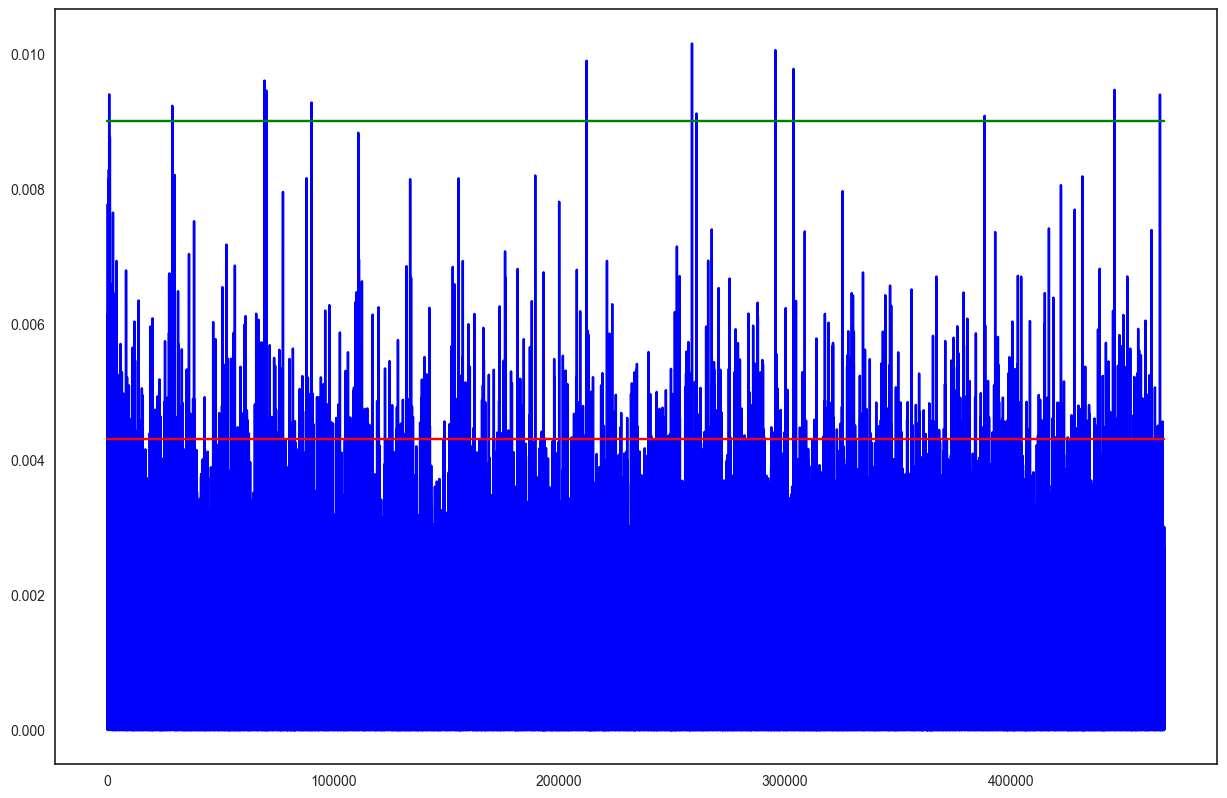

In [28]:
residual_pca1 = X_train_nom - X_train_rec
residual_pca2 = np.square(residual_pca1)
residual_pca = residual_pca2.sum(axis=1) 

figure, ax = plt.subplots(figsize=[15,10])
plt.figure(figsize=[25,10])
ax.plot(residual_pca,'b')
ax.plot([0,len(residual_pca)],[threshold,threshold],'r')
ax.plot([0,len(residual_pca)],[0.009,0.009],'g')
print 'percentage of Abnormal data in training data:', 1.0 * sum(residual_pca>threshold)/len(residual_pca)


Using the Q-statistic test, we can get a threshold as illustrated in the picture above(the red line). However ,it seems that the threshold is not optimal for our case.Therefore, we manually choose a threshold (the green line above), which give us fewer false positives. The threshold (red line) results in few false positive which only takes up 0.20% of the training data.

After we applied the pca on the training data and tuned the threshold, it is really crucial that we transfer the same pca and normalizaion to the test data. The Figure below shows the ture label and the predicted label.

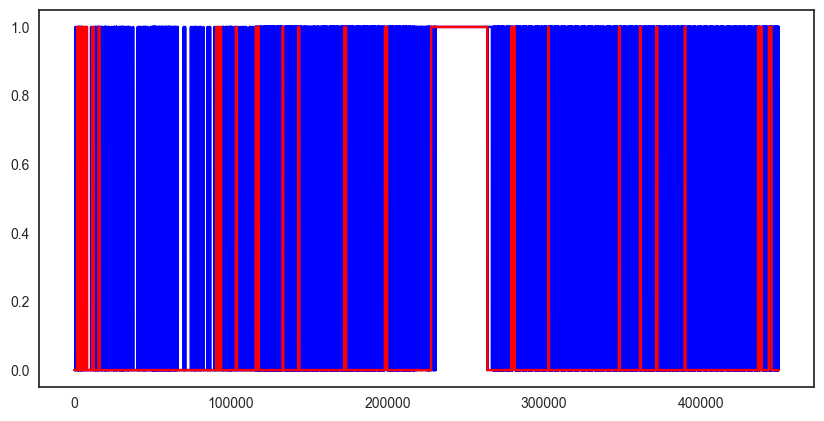

In [29]:
#test
X_test_nom = scaler.transform(X_test) # apply the same normalization with training data
lowDDataMat_test=X_test_nom*P       # apply the same pca with training data
reconMat_test=(lowDDataMat_test*P.T)
residual_test1 = X_test_nom-reconMat_test
residual_test2 = np.square(residual_test1)
residual_test = residual_test2.sum(axis=1) 

figure, ax = plt.subplots(figsize=[10,5])
ax.plot(residual_test>threshold,'b')# plot the predicted label
ax.plot(1*y_test.values,'r')# plot the true label



In [30]:
residual_test = np.array(residual_test).reshape([1,449919])[0]

We used the threshold given by Q-statistic test first.and calculated the precision and recall.

In [31]:
predict_y = residual_test > threshold

In [32]:
tp = sum(predict_y * y_test.values)
print 'TP:',tp
fp = sum((y_test.values - predict_y)==-1)
print 'FP:',fp
tn = sum(predict_y[y_test.values==0]==0)
print 'TN:',tn
fn = sum(predict_y[y_test.values==1]==0)
print 'FN:',fn
print 'precision:' ,1.0 * tp/(tp+fp)
print 'recall:' ,1.0 * tp/(tp+fn)

TP: 44003.0
FP: 143082
TN: 252937
FN: 9897
precision: 0.23520324986
recall: 0.816382189239


Then, we used the threshold chose by ourselves from the figure.Threshold_1 =0.009.

In [33]:
residual_test = np.array(residual_test).reshape([1,449919])[0]
threshold_1 = 0.009
predict_y = residual_test > threshold_1
tp = sum(predict_y * y_test.values)
print 'TP:',tp
fp = sum((y_test.values - predict_y)==-1)
print 'FP:',fp
tn = sum(predict_y[y_test.values==0]==0)
print 'TN:',tn
fn = sum(predict_y[y_test.values==1]==0)
print 'FN:',fn

print 'precision:' ,1.0 * tp/(tp+fp)
print 'recall:' ,1.0 * tp/(tp+fn)

TP: 41703.0
FP: 80240
TN: 315779
FN: 12197
precision: 0.341987649968
recall: 0.773710575139


### ARMA Task
For ARMA task, we did it in several steps:
* Data preprocessing
* Study the first three signals
* Learn a ARMA model for other signals
* Combine predictions into a single anomaly detection algorithm


#### step1: Preprocessing
* Downsample the data to improve efficiency
* Rescale to obtain zero mean and unit variance

In [34]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

# Resampling: downsample the data to improve efficiency
X_train = X_train.resample('1Min').mean()

def resampler(arrays):
    for array in arrays:
        if array=='Attack':
            return 'Attack'
    return 'Normal'

y_test_arma=y.resample('1Min').apply(resampler)
X_test = X_test.resample('1Min').mean()

In [35]:
from sklearn.preprocessing import StandardScaler
# Rescale
def norm_scale(series,series_test):
    # Remove first day (intialize)
    series = series['2015-12-24':]
    # Rescale
    index1= series.index
    index2 = series_test.index
    scaler = StandardScaler().fit(series.values)
    series = scaler.transform(series.values)
    series_test = scaler.transform(series_test.values)
    # update scaled value
    series = pd.Series(series,index=index1)
    series_test = pd.Series(series_test,index=index2)
    return series,series_test

#### step2: Study the first three signals
 Here are the first three signals: 'LIT101','FIT101', 'AIT201'.
 

In [36]:
signal_names = ['LIT101','FIT101', 'AIT201']

#### First signal: LIT101

In [37]:
# Select a signal
series = X_train[signal_names[0]]
series_test = X_test[signal_names[0]]
series,series_test = norm_scale(series,series_test)

E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it conta

Here are some help functions for autocorrelation plots, fit and predict and plot residuals.

In [38]:
def autocorrelation_plots(series,lags=50):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(series.values.squeeze(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax2)

# Since there is no build-in function to predict from new observations, 
# I wrote a help function to do both fitting and prediction.
def fit_and_predict(series,series_test,order=(4,0,0)):
    # First, learn a model from training data
    mod1 = sm.tsa.SARIMAX(series, order=order)
    res1 = mod1.fit()
    predict = pd.Series()
    start = series_test.index[0]
    # Second, predict the future using testing data and trained model
    for t in series_test.index:
        mod2 = sm.tsa.SARIMAX(series_test[start:t], order=order)
        res2 = mod2.filter(res1.params)
        predict = predict.append(res2.forecast(1))
    return predict

def plot_residual(series_test, predict,num):
    fig,ax = plt.subplots(figsize=(12, 8))
    #ax.plot(max(series_test.ix[1:num+1] - predict[0:num])*y_test_1.ix[1:num+1])
    ax.plot(series_test.ix[1:num+1] - predict[0:num])

#### Autocorrelation plot
The autocorrelation plot helped us to decide what the order should be.

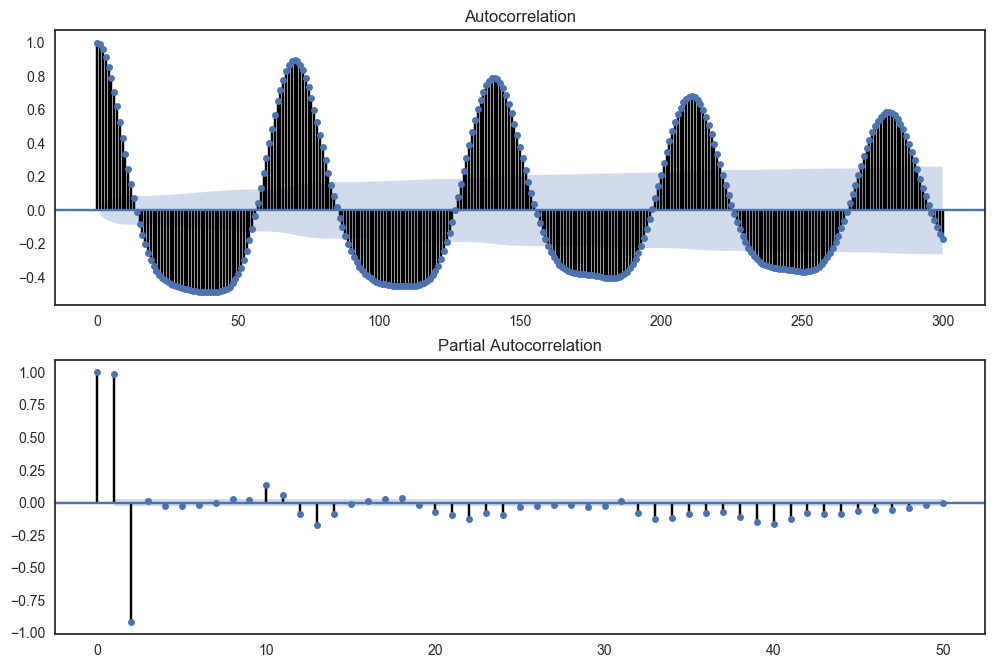

In [39]:
autocorrelation_plots(series,300)
order = (4,0,0)

In [505]:
predict = fit_and_predict(series,series_test,order=order)

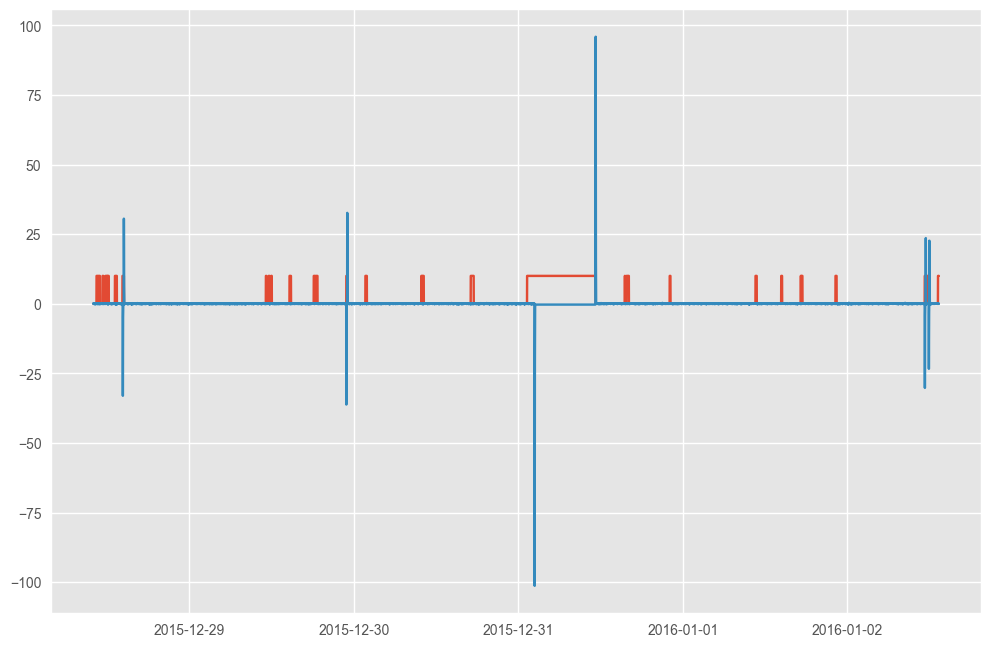

In [456]:
plot_residual(series_test, predict,7400)

#### Second signal: 

E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it conta

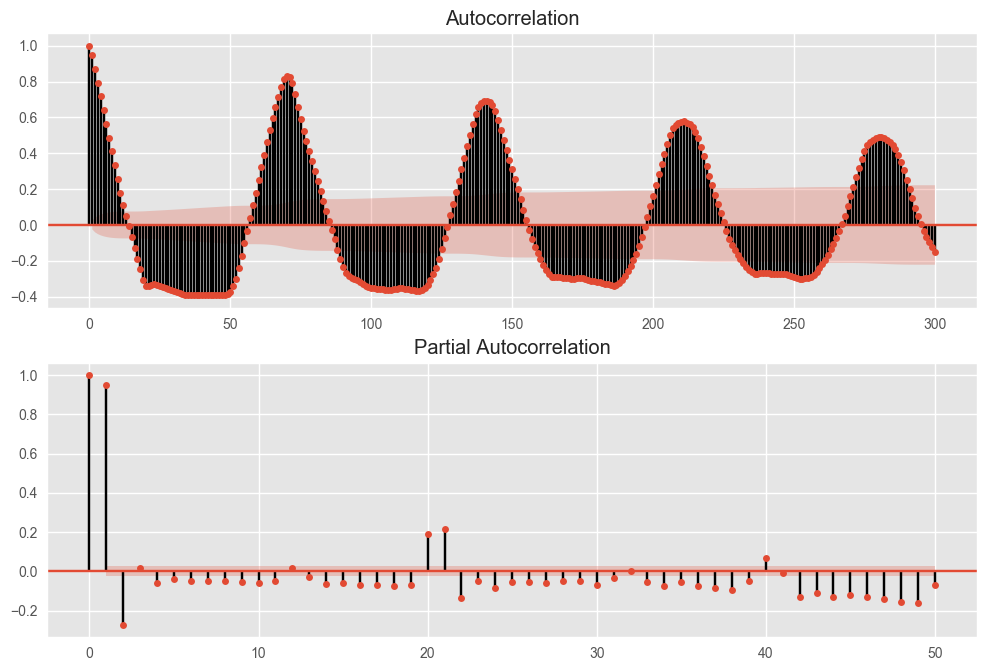

In [593]:
series = X_train[signal_names[1]]
series_test = X_test[signal_names[1]]
series,series_test = norm_scale(series,series_test)

autocorrelation_plots(series,300)
order = (4,0,0)

In [588]:
predict = fit_and_predict(series,series_test,order=order)

#### Third signal:

E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it conta

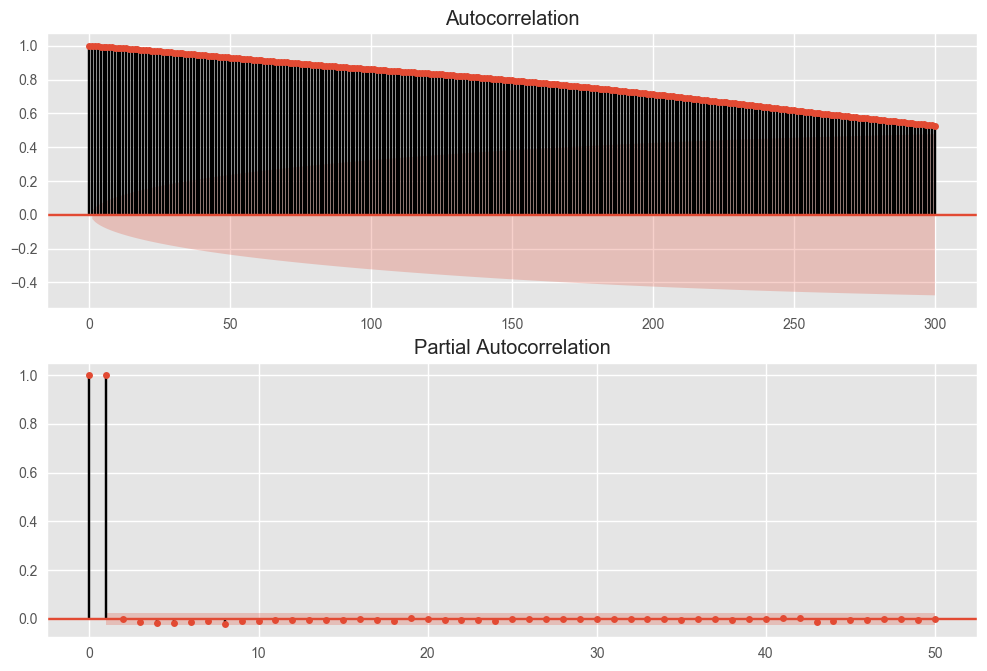

In [591]:
series = X_train[signal_names[2]]
series_test = X_test[signal_names[2]]
series,series_test = norm_scale(series,series_test)

autocorrelation_plots(series,300)
order = (3,0,0)

In [672]:
predict = fit_and_predict(series,series_test,order=order)
plot_residual(series_test, predict,7400)

#### Step3: create ARMA models for other signals

In [466]:
# Create an empty dataframe
anomaly_detection = pd.DataFrame()
anomaly_detection['label'] = y_test_arma

E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
E:\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it conta

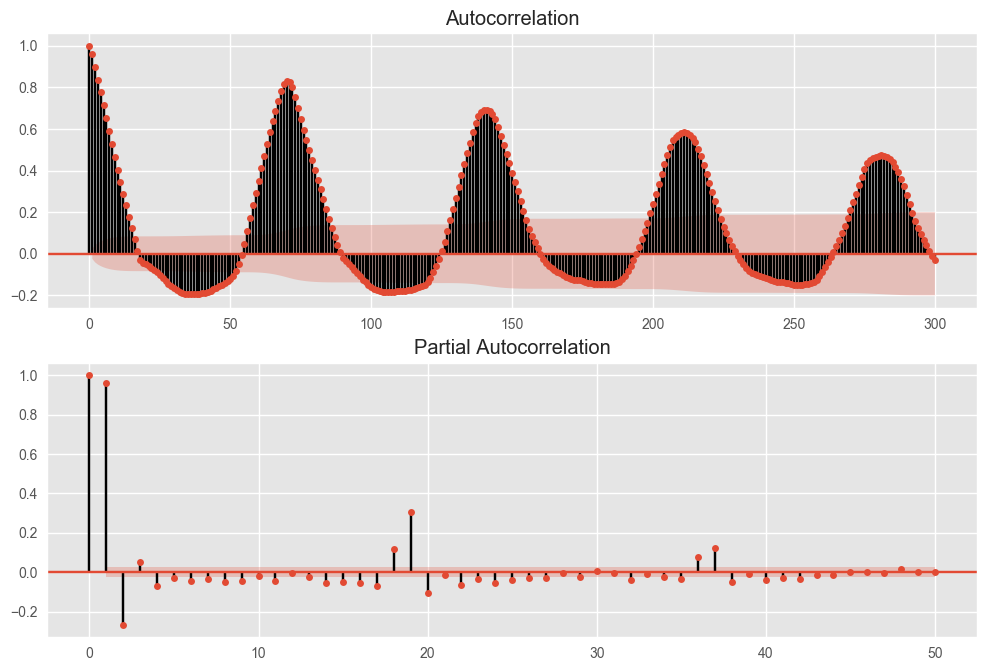

In [1127]:
signal_name = 'AIT202'
series = X_train[signal_name]
series_test = X_test[signal_name]
series,series_test = norm_scale(series,series_test)

autocorrelation_plots(series,300)

In [1128]:
order = (4,0,0)
predict = fit_and_predict(series,series_test,order=order)
anomaly_detection[signal_name] =abs(predict - series_test)

In [1156]:
#plot_residual(predict=predict, series_test=series_test,num=5000)

#### Step 4: Combine predictions
Finally, we can combine all the predictions to a single anomaly detection method. For this task, we simply combined these predictions using "or" operator. This may help to increase recall.

In [42]:
def performance_measure(data, mask):
    tp = sum(data[mask]['label']=='Attack')
    fp = sum(data[mask]['label']=='Normal')
    tn = sum(data['label']=='Normal') - fp
    fn = sum(data['label']=='Attack') - tp
    print ""
    print '*********ARMA Result**********'
    print 'Accuracy:  ', 1.0 * (tp+tn)/(tp+fp+tn+fn)
    print 'Precision: ', 1.0 * tp / (tp + fp)
    print 'Recall:    ', 1.0 * tp / (tp + fn)
    print '******************************'
    #return tp,fp,tn,fn

##### NOTICE!
Here you need to place the .csv file in the same folder.
The .csv file contains arma residuals for  9 different signals.

In [43]:
anomaly_detection = pd.read_csv('arma_residual.csv',index_col=' Timestamp')
anomaly_detection.head()

,label,FIT501,FIT101,LIT101,AIT201,FIT401,LIT301,FIT201,AIT504,AIT202
Timestamp,,,,,,,,,,
2015-12-28 10:00:00,Normal,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2015-12-28 10:01:00,Normal,0.086440,0.043766,0.001755,0.043766,0.175532,0.029856,0.033769,0.007364,0.029495
2015-12-28 10:02:00,Normal,0.048164,0.029182,0.012666,0.029182,0.021749,0.038252,0.040258,0.057127,0.030781
2015-12-28 10:03:00,Normal,0.156599,0.036304,0.003709,0.036304,0.062826,0.019170,0.041698,0.033381,0.045652
2015-12-28 10:04:00,Normal,0.041074,0.063834,0.007850,0.063834,0.090731,0.023290,0.042528,0.012329,0.001703


Here we used the same methods as PCA to find these thresholds which can result in few false positives in PCA 

In [44]:
mask1 = anomaly_detection['FIT501']>0.30 #or anomaly_detection['FIT101']>0.3
mask2 = (anomaly_detection['LIT101']>0.30)
mask3 = (anomaly_detection['FIT401']>=0.5)
mask4 = (anomaly_detection['LIT301']>=0.5)
mask5 = (anomaly_detection['AIT201']>=2)
mask6 = (anomaly_detection['AIT504']>=1.5)
mask7 = (anomaly_detection['AIT202']>=2.5)
# Combine these predictions: using "or"
performance_measure(anomaly_detection,mask1|mask2|mask3|mask4|mask5|mask6|mask7)


*********ARMA Result**********
Accuracy:   0.941066666667
Precision:  0.83606557377
Recall:     0.655246252677
******************************


### comparision task  
For this task, We chose point-wise (every minute) precision and recall to compare these two anomaly detection methods.  
The reason for choosing this method is that it is a simple and effective. Precision tells us when the anomaly detection system gives an alert, how likely, in satistical terms, it is a true attack. In our anomaly detection system, we want a high precision, because we don't want to have too many false alerts. Recall is a statistical term which reveals the ability to identify all the anomaly. We want to have a high recall simply becuase we don't want to miss too many attacks.

In this part, we compared these two methods in the following steps:

* downsample the training and testing data to the leval of minute for pca
* compare these two methods

#### step1: down sampling
Because the ARMA is based on minute and PCA above is based on second. We first need to down sample for the PCA to the same level of point-wise with ARMA.

In [45]:
def pca_resampler(arrays):
    for array in arrays:
        if array==1:
            return 1
    return 0

def pca_performance_measure(residual, threshold):
    predict_y = residual_test > threshold
    pca_predict_y = pd.Series(predict_y,index=y_test.index)
    pca_predict_y = pca_predict_y.resample('1Min').apply(pca_resampler)

    pca_y = y_test.resample('1Min').apply(pca_resampler)
    tp = sum(pca_predict_y.values * pca_y.values)
    fp = sum((pca_y.values - pca_predict_y.values)==-1)
    tn = sum(pca_predict_y[pca_y.values==0]==0)
    fn = sum(pca_predict_y[pca_y.values==1]==0)
    print ""
    print '**********PCA Result**********'
    print 'Accuracy:  ', 1.0 * (tp+tn)/(tp+fp+tn+fn)
    print 'precision: ' ,1.0 * tp/(tp+fp)
    print 'recall:    ' ,1.0 * tp/(tp+fn)
    print "******************************"

#### Step 2： compare these 2 methods

As discussed above, we applied two different methods for anomaly detection: ARMA and PCA. 

##### ARMA MODEL
For ARMA model, it analyzed multiple signals and then combined their predictions. Here it achieved quite reasonable and applicable result. However, it has several drawbacks:

1. We need to select stationary signals and build models for every signal, which is time-consuming.
2. In training phase, it takes a lot of time to model all those signals.
3. Because of the limit of time and computing power, we neeed to downsample signals to "minute".

##### PCA MODEL
For PCA model, it reconstructs data into principle component space and calculate the residual between original data and reconstructed data. Due to the fact that top few principal components capture variability in noadvantagesrmal data while outliers have variability in the smallest component, we can use the residual and set a threshold to detect the anomaly. It have several advantages and disadvantages:

Advantages:

1. It can be operated in an unsupervised mode.
2. It is a kind of dimension reduction methods which is suitable for high dimensional data.
3. simpler and faster than ARMA.

Disadvantages:

1. It is based on the assumption that anomalies and normal instances are distinguishable in the reduced space.

From the results below, we find that the PCA give better recall and ARMA give better precision. We would like to recommend PCA and there are severl reasons. First, in our case, recall is more important than precision cause we don't want to miss any dangerous attacks. Second, PCA is much faster and  simpler than ARMA, especially for high dimensional signals.



In [46]:
#residual_test = np.array(residual_test).reshape([1,449919])[0]
pca_performance_measure(residual_test,threshold_1)
performance_measure(anomaly_detection,mask1|mask2|mask3|mask4|mask5|mask6|mask7)


**********PCA Result**********
Accuracy:   0.589066666667
precision:  0.208785249458
recall:     0.824411134904
******************************

*********ARMA Result**********
Accuracy:   0.941066666667
Precision:  0.83606557377
Recall:     0.655246252677
******************************
